In [8]:
from skspatial.objects import Line, Points, LineSegment
import scipy.stats
from skspatial.plotting import plot_3d
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import itertools

'''
TODO:
    ideas: 
        1. prune lines that are too close to eachother
        2. after 10 iterations, add everything to the same cluster and try to do clustering again
        3. seperate line into segments if the point projections onto like line using transform_points()
'''

class Line3D:
    def __init__(self, start, end):
        self.e = np.array([0, 0, 0])
        self.s = np.array([0, 0, 0])
        self.update_line(start, end)
    

    def get_length_direction(self):
        diff = np.subtract(self.e, self.s)
        length = np.linalg.norm(diff)
        diff = diff/length
        return  length, diff

    def update_line(self, start, end):
        if type(start) == list:
            self.s = np.array(start)
        else:
            self.s = start

        if type(end) == list:
            self.e = np.array(end)
        else:
            self.e = end

        self.length, self.direction = self.get_length_direction()
        self.skLine = Line(self.s, self.direction)
    
    def generate_pts_from_line(self, density, v):
        total_points = round(self.length/density)
        points = np.zeros((total_points,3))
        mean = [0, 0, 0]
        cov = np.identity(3) * v
        noise = np.random.multivariate_normal(mean,cov,total_points)

        for i in range(total_points):
            points[i] = self.direction*i*density + self.s + noise[i]
        
        return Points(points)
    
    def get_dist(self, point):

        p = self.skLine.project_point(point)

        vec_s = p-self.s
        vec_e = p-self.e
        d_product = np.dot(vec_s, vec_e)
        if d_product < 0:
            dist = self.skLine.distance_point(point)
        else:
            dist = min(np.linalg.norm(point-self.s), np.linalg.norm(point-self.e))
        return dist

    def isclose(self, other):
        return np.allclose(self.direction, other.direction,atol=1) and self.get_dist(other.s) < 1 and self.get_dist(other.e) < 1
    def __eq__(self,other):
        return isinstance(other,Line3D) and np.all(self.s == other.s) and np.all(self.e == other.e)

    def __hash__(self):
        return id(self)
        
class KNN:
    def __init__(self, pointcloud, variance, probability = 0.9, num_lines = 1) -> None:
        
        self.total_iterations = 0
        self.pointcloud = pointcloud
        
        self.lines = []
        self.line_pointclouds = {} 
        self.unused_points = []

        self.v = variance
        self.prob = probability

        self.nd = scipy.stats.norm(0, math.sqrt(variance))
        for i in range(num_lines):
            self.lines.append(self.init_line())
            self.line_pointclouds[self.lines[-1]] = np.array([])

    def init_line(self):
        selection = np.random.choice(self.pointcloud.shape[0], 2, replace = False)
        return Line3D(self.pointcloud[selection[0]], self.pointcloud[selection[1]])

    def get_dist(self, point, line):

        p = line.skLine.project_point(point)

        vec_s = p-line.s
        vec_e = p-line.e
        d_product = np.dot(vec_s, vec_e)
        if d_product< 0:
            dist = line.skLine.distance_point(point)
        else:
            dist = min(np.linalg.norm(point-line.s), np.linalg.norm(point-line.e))
        return dist
    
    def include_criteria(self, dist, line, point):
        prob = self.nd.pdf(dist)
        if prob > 1-self.prob:
            return True
        else:
            return False

    def fit(self, iterations = 1):
        for i in range(iterations):
            self.point_segmentation()
            self.update_lines()
            self.total_iterations += 1
    
    def point_segmentation(self):
        for ptcld in self.line_pointclouds:
            self.line_pointclouds[ptcld] = []
        self.unused_points = []
        for p in self.pointcloud:
            dists = []
            for i, l in enumerate(self.lines):
                dists.append(self.get_dist(p, l))
            
            tmp = min(dists)
            if self.include_criteria(tmp, self.lines[dists.index(tmp)], p):
                self.line_pointclouds[self.lines[dists.index(tmp)]].append(p)
            else:
                self.unused_points.append(p)
    
    def update_lines(self):
        for line in self.line_pointclouds:
            points = Points(self.line_pointclouds[line])

            lobf = Line.best_fit(points)
            
            dists = lobf.transform_points(points)
            min_dist = min(dists)
            max_dist = max(dists)
            start = lobf.point+lobf.direction*min_dist
            end = lobf.point+lobf.direction*max_dist

            line.update_line(start, end)
    
    def prune_lines(self):
        del_list = []
        chosen_line = None
        for (ix, x), (iy, y) in itertools.combinations(enumerate(self.line_pointclouds),2):
            if x == y:
                print("2 lines are equal")
                if chosen_line == None:
                    chosen_line = x
                    del_list.append(y)
                elif chosen_line == x:
                    del_list.append(y)
            elif x.isclose(y,atol=0.01):
                print("Lines are close")
                del_list.append(y)
                if chosen_line == None:
                    chosen_line = x
                    del_list.append(y)
                elif chosen_line == x:
                    del_list.append(y)
        for item in del_list:
            self.line_pointclouds[chosen_line].extend(self.line_pointclouds[item])
            del self.line_pointclouds[item]

            
            

In [11]:
line = Line3D([30,0.01,0], [0,0.01,0])
line2 = Line3D([40,0.0101,0], [0,0.01,0])
print(line.isclose(line2))


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3191854310.py, line 2)

900 900


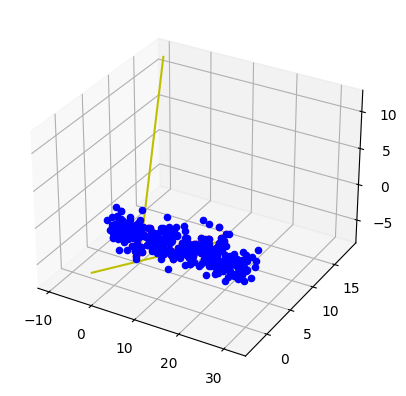

In [204]:


Variance = 1

line = Line3D([30,0,0], [0,0,0])
line2 = Line3D([30,0,0], [0,0,0])
p = line.generate_pts_from_line(0.1, Variance)
#p2 = line2.generate_pts_from_line(0.1, Variance)




#pointcloud = np.concatenate((np.array(p), np.array(p2)))
pointcloud = Points(p)
print(pointcloud.size, p.size)
fig = plt.figure(0)
ax = fig.add_subplot(111,projection='3d') 
pointcloud.plot_3d(ax, c='b',depthshade=False)

classifier = KNN(pointcloud, Variance, 0.9, 2)
for i in range(1,2):
    classifier.fit()
    for l in classifier.lines:
        points = Points(classifier.line_pointclouds[l])
        l.skLine.plot_3d(ax, t_1=0, t_2=line.length, c='y')
        points.plot_3d(ax, c='r', depthshade=False)

classifier.prune_lines()